<a href="https://colab.research.google.com/github/yanapatt/Smart-Skin-Cancer-Assistant-CNN-Model/blob/main/PreparationDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Preparation Dataset**
---
**คำอธิบาย**  
ไฟล์ Jupyter notebook นี้ใช้สำหรับการจัดเตรียมรูปภาพให้พร้อมก่อนที่จะนำภาพเข้าโมเดล CNN ซึ่งประกอบไปด้วย

1.   การโหลด Dataset จาก Kaggle
2.   การจัดเตรียม Directory สำหรับดึง Image ไปใช้งาน
3.   การแบ่งข้อมูล Training, Validation และ Testing โดยเก็บเป็น Index ในรูปแบบ .csv เพื่อใช้ซ้ำในครั้งถัดไป
4.   การ Visualization images เพื่อรายงานผลเบื้องต้นเกี่ยวกับ Dataset
5.   เสริมการแก้ Imbalanced Dataset ด้วยการ Augmentation

---
**Group Oscar Do Everything**  
**หัวข้อ Smart Skin Cancer Assistant CNN Model**  
**สมาชิก**  

* 66102010137	นายณัฐนนท์ หลิมเหล็ก
* 66102010145	นายพชรดนัย กุระกนก
* 66102010153	นายศิลายุชย์ โชติธรรมาภรณ์
* 66102010236	นายญาณภัทร ปานเกษม

**รายวิชา**
**CP461 Introduction to Computer Vision**

**Main Reference : An Interpretable Deep Learning Approach for Skin Cancer Categorization**  

**Paper Link:** https://arxiv.org/abs/2312.10696  
**GitHub:** https://github.com/Faysal-MD/An-Interpretable-Deep-Learning-Approach-for-Skin-Cancer-Categorization-IEEE2023?utm_source=chatgpt.com  
**EDA:** https://www.kaggle.com/code/abhishekgbhat/eda-cnn-architecture-tuning-80-83-accuracy#Univariate-EDA

## **Section 0: Import important library**

In [1]:
import pandas as pd
import numpy as np
import random as rd
import tensorflow as tf
import keras
import sklearn
import joblib

import kagglehub
import os
import shutil
import glob
from tqdm import tqdm
import albumentations as A

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import missingno as msno
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Setting a seed system environment**

In [3]:
def set_seed(seed):
    """
        ใช้สำหรับการตั้งค่า Seed Environment เพื่อให้ผลลัพธ์สามารถ Reproduce ได้
        Arg:
            seed คือ ค่า Integer สำหรับกำหนด Seed
    """
    tf.random.set_seed(seed)
    tf.config.experimental.enable_op_determinism()
    keras.utils.set_random_seed(seed)

    np.random.seed(seed)
    rd.seed(seed)

    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"

    print(f"The seed number has been set at {seed}")

In [4]:
SEED = 42
set_seed(SEED)

The seed number has been set at 42


## **Section 1: Preparing the directory for dataset**

### **In G-Drive Directory**

In [5]:
DRIVE_DIR = "/content/drive/MyDrive/CP461/mainProject" # Drive Directory
ASSETS_PATH = f"{DRIVE_DIR}/assets" # Assets Path
ASSETS_VISUALIZE_IMG_PATH = f"{ASSETS_PATH}/images" # Visualize Image Assets Path
DATASET_ZIP_PATH = f"{DRIVE_DIR}/datasets/ham10000Dataset"
OVER_DATASET_ZIP_PATH = f"{DRIVE_DIR}/datasets/ham10000DatasetOversampling"
INDEX_PATH = f"{DRIVE_DIR}/datasets/indexSetting"

In [6]:
# Setting font
fm.fontManager.addfont(f"{ASSETS_PATH}/fonts/OPTITimes-Roman.otf")
font_prop = fm.FontProperties(fname=f"{ASSETS_PATH}/fonts/OPTITimes-Roman.otf")
font_name = font_prop.get_name()
plt.rcParams["font.family"] = font_name

### **In Runtime Directory**

In [ ]:
KAGGLE_BASE_DIR = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")
print("Path to dataset files:", KAGGLE_BASE_DIR)

Using Colab cache for faster access to the 'skin-cancer-mnist-ham10000' dataset.
Path to dataset files: /kaggle/input/skin-cancer-mnist-ham10000


In [ ]:
METADATA_PATH = f"{KAGGLE_BASE_DIR}/HAM10000_metadata.csv"
IMAGE_PART_ONE = f"{KAGGLE_BASE_DIR}/HAM10000_images_part_1"
IMAGE_PART_TWO = f"{KAGGLE_BASE_DIR}/HAM10000_images_part_2"

In [ ]:
IMAGE_PART_ONE_PATH = glob.glob(os.path.join(IMAGE_PART_ONE, "*.jpg"))
IMAGE_PART_TWO_PATH = glob.glob(os.path.join(IMAGE_PART_TWO, "*.jpg"))
MERGE_IMAGES = IMAGE_PART_ONE_PATH + IMAGE_PART_TWO_PATH

In [ ]:
paths_dict = {os.path.basename(x).split(".")[0] : x for x in MERGE_IMAGES}
print(f"Number of dictionary elements: {len(paths_dict)}")

Number of dictionary elements: 10015


In [7]:
BASE_DATASET_DIR = "/content/ham10000Dataset"
OVER_DATASET_DIR = "/content/ham10000DatasetOversampling"

##**Section 2: Exploratory Data Analysis (EDA)**

### **Read metadata**

In [ ]:
metadata = pd.read_csv(METADATA_PATH)
metadata

lesion_id      image_id     dx dx_type   age     sex localization
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear
...            ...           ...    ...     ...   ...     ...          ...
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back

[10015 rows x 7 columns]

In [ ]:
print("Metadata before cleaning detail")
print("-------------------------------------------")
print(f"Shape of metadata: {metadata.shape}")
print(f"Row of metadata: {metadata.shape[0]}")
print(f"Column of metadata: {metadata.shape[1]}")
print("-------------------------------------------")
print("Check missing value")
print("-------------------------------------------")
print(metadata.isnull().sum())
print("-------------------------------------------")
print("Check data type")
print("-------------------------------------------")
print(metadata.dtypes)
print("Check duplicate value")
print("-------------------------------------------")
print(f"Duplicate value count : {metadata.duplicated().sum()}")

Metadata before cleaning detail
-------------------------------------------
Shape of metadata: (10015, 7)
Row of metadata: 10015
Column of metadata: 7
-------------------------------------------
Check missing value
-------------------------------------------
lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64
-------------------------------------------
Check data type
-------------------------------------------
lesion_id        object
image_id         object
dx               object
dx_type          object
age             float64
sex              object
localization     object
dtype: object
Check duplicate value
-------------------------------------------
Duplicate value count : 0


<Axes: >

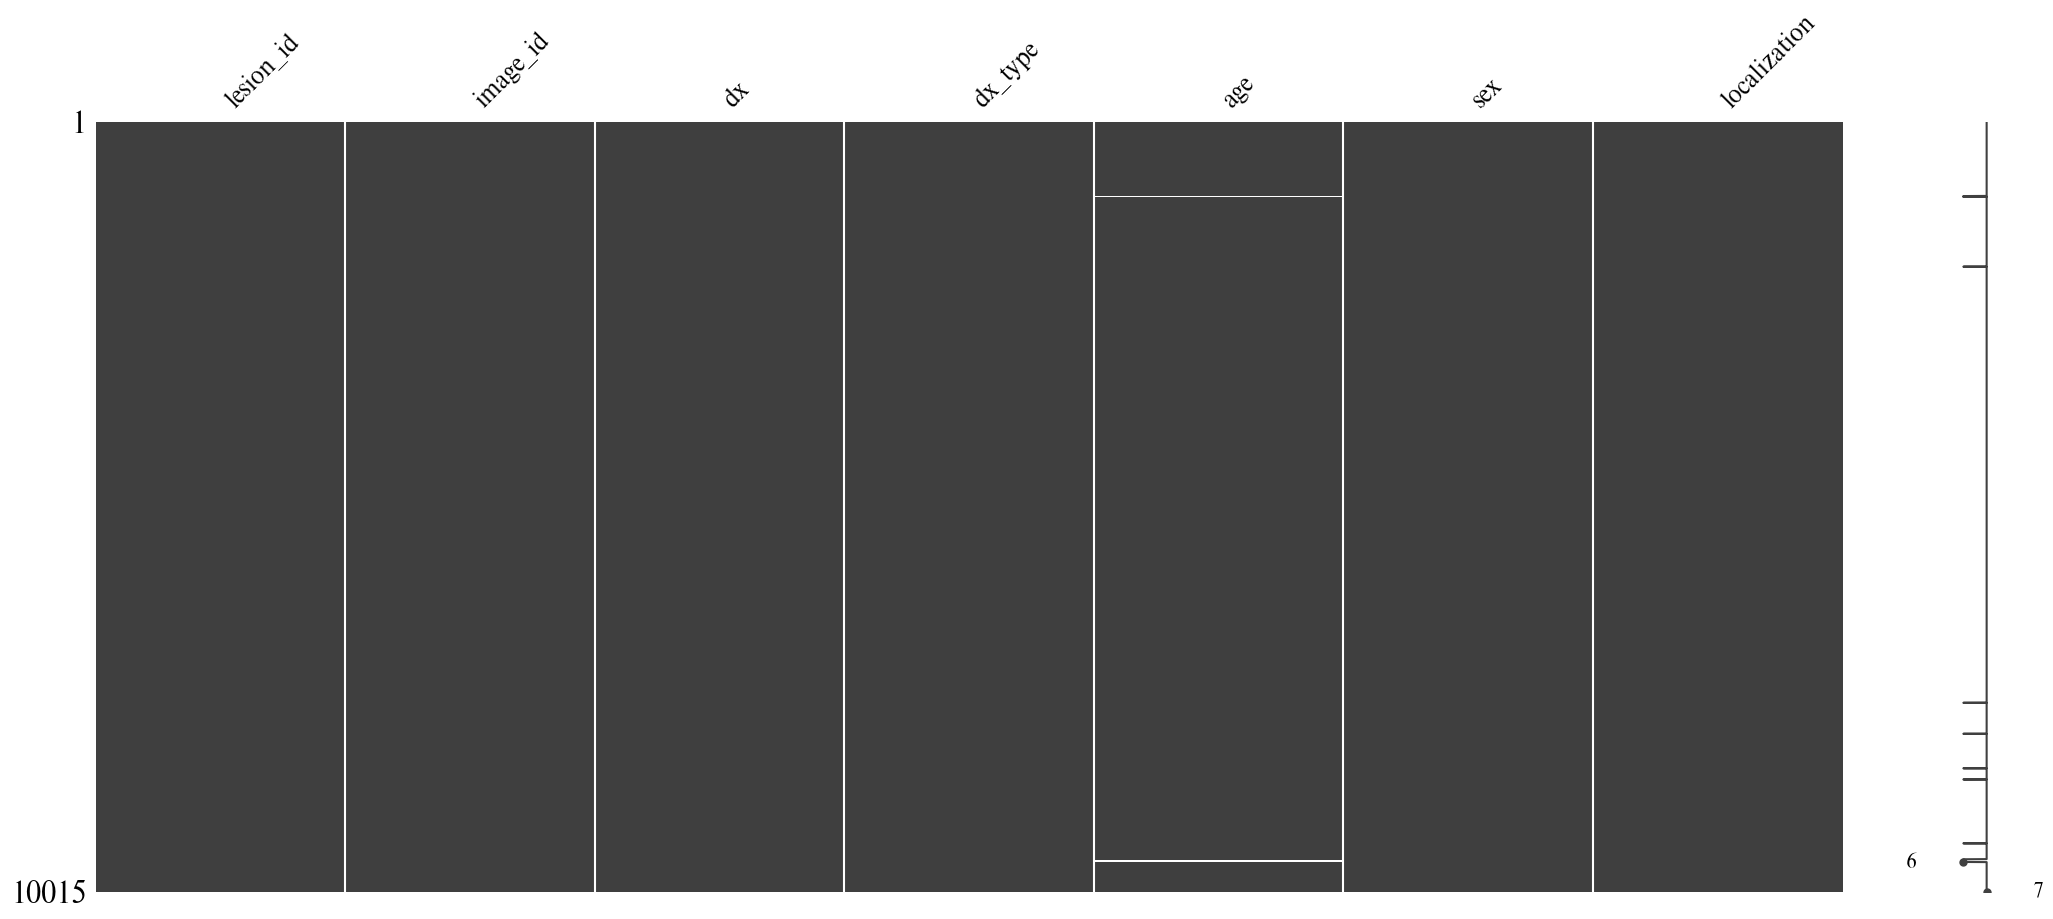

In [ ]:
msno.matrix(metadata)

In [ ]:
print("Metadata age describe")
print("-------------------------------------------")
print(metadata["age"].describe())
print("Metadata age median")
print("-------------------------------------------")
print(f"Age median: {metadata['age'].median()}")

Metadata age describe
-------------------------------------------
count    9958.000000
mean       51.863828
std        16.968614
min         0.000000
25%        40.000000
50%        50.000000
75%        65.000000
max        85.000000
Name: age, dtype: float64
Metadata age median
-------------------------------------------
Age median: 50.0


In [ ]:
clean_df = metadata.copy()

### **Handle missing value for age column**

In [ ]:
age_median = clean_df["age"].median()
clean_df["age"] = clean_df["age"].fillna(age_median) # แทนที่ค่า NaN ด้วยค่ามัธยฐานของอายุ

print("Check missing value")
print("-------------------------------------------")
print(clean_df.isnull().sum())
print("-------------------------------------------")

Check missing value
-------------------------------------------
lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64
-------------------------------------------


<Axes: >

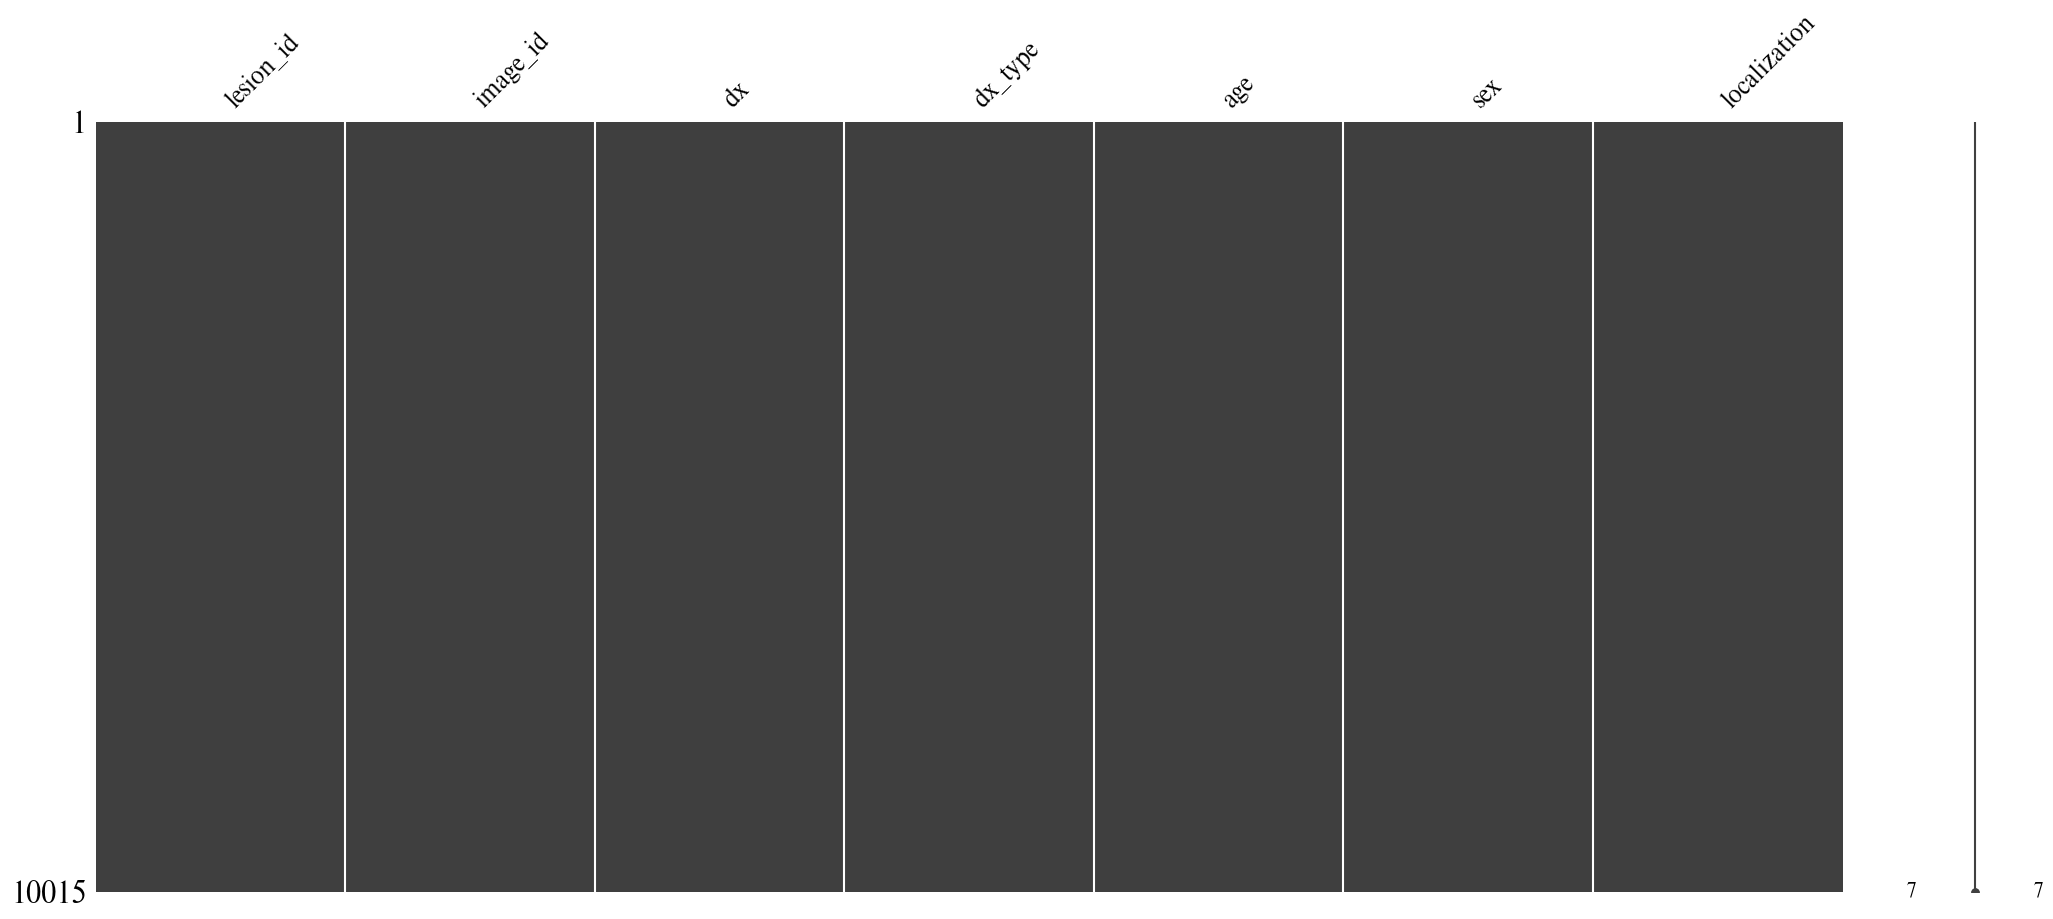

In [ ]:
msno.matrix(clean_df)

### **Mapping imagepath, full label and class index**

In [ ]:
lesion_type_dict = {
    "akiec": "Actinic keratoses",
    "bcc": "Basal cell carcinoma",
    "bkl": "Benign keratosis-like lesions",
    "df": "Dermatofibroma",
    "mel": "Melanoma",
    "nv": "Melanocytic nevi",
    "vasc": "Vascular lesions"
} # เพื่อให้ลำดับ Index เหมือนตอน Train โมเดล

lesion_type_mapping = {v: k for k, v in enumerate(lesion_type_dict.values())}

clean_df["filepaths"] = clean_df["image_id"].map(paths_dict.get)
clean_df["cell_type"] = clean_df["dx"].map(lesion_type_dict.get)
clean_df["cell_type"] = pd.Categorical(
    clean_df["cell_type"],
    categories=[lesion_type_dict[k] for k in lesion_type_dict.keys()],
    ordered=True
)
clean_df["cell_type_idx"] = clean_df["cell_type"].cat.codes

clean_df

lesion_id      image_id     dx dx_type   age     sex localization  \
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp   
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp   
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp   
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp   
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear   
...            ...           ...    ...     ...   ...     ...          ...   
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen   
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen   
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen   
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face   
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back   

                                               filepaths  \
0      /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
1      /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
2      /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
3      /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
4      /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
...                                                  ...   
10010  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
10011  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
10012  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
10013  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
10014  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   

                           cell_type  cell_type_idx  
0      Benign keratosis-like lesions              2  
1      Benign keratosis-like lesions              2  
2      Benign keratosis-like lesions              2  
3      Benign keratosis-like lesions              2  
4      Benign keratosis-like lesions              2  
...                              ...            ...  
10010              Actinic keratoses              0  
10011              Actinic keratoses              0  
10012              Actinic keratoses              0  
10013              Actinic keratoses              0  
10014                       Melanoma              4  

[10015 rows x 10 columns]

In [ ]:
print("Recheck class index and cell type")
clean_df[["dx", "cell_type", "cell_type_idx"]].drop_duplicates().sort_values("cell_type_idx").reset_index(drop=True)

Recheck class index and cell type


dx                      cell_type  cell_type_idx
0  akiec              Actinic keratoses              0
1    bcc           Basal cell carcinoma              1
2    bkl  Benign keratosis-like lesions              2
3     df                 Dermatofibroma              3
4    mel                       Melanoma              4
5     nv               Melanocytic nevi              5
6   vasc               Vascular lesions              6

### **Univariate EDA**

In [ ]:
def plot_univariate_distributions(df, save_path=None, fontsize=20):
    """
    ฟังก์ชันนี้ใช้สร้างกราฟแสดงการแจกแจงตัวแปรเดี่ยว (Univariate Distributions)
    จาก DataFrame ที่มีคอลัมน์ ['age', 'sex', 'dx_type', 'localization']

    Args:
        df (DataFrame): ข้อมูลที่ต้องการวิเคราะห์ โดยต้องมีคอลัมน์ 'age', 'sex', 'dx_type', 'localization'
        save_path (str, optional): ถ้าระบุ จะบันทึกภาพกราฟเป็นไฟล์ PNG และ SVG
        fontsize (int, optional): ขนาดตัวอักษรฐานสำหรับ Label และ Title (default=20)
    """
    plt.rcParams['axes.titlesize'] = fontsize
    plt.rcParams['axes.labelsize'] = fontsize * 0.85
    plt.rcParams['xtick.labelsize'] = fontsize * 0.75
    plt.rcParams['ytick.labelsize'] = fontsize * 0.75

    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    sns.despine(left=True)

    # ---- [0, 0] Age Distribution (KDE) ----
    sns.kdeplot(data=df, x="age", fill=True, color="skyblue", ax=axes[0, 0])
    axes[0, 0].set_xlabel("Age")
    axes[0, 0].set_title("Age Distribution", fontsize=fontsize)

    # ---- [0, 1] Gender Distribution ----
    sns.countplot(data=df, x="sex", hue="sex", palette="pastel", legend=False, ax=axes[0, 1])
    axes[0, 1].set_xlabel("Gender")
    axes[0, 1].set_ylabel("Count")
    axes[0, 1].set_title("Gender Distribution", fontsize=fontsize)
    axes[0, 1].tick_params(axis='x', rotation=30)

    # ---- [1, 0] Diagnosis Test Type ----
    sns.countplot(data=df, x="dx_type", hue="dx_type", palette="muted", legend=False, ax=axes[1, 0])
    axes[1, 0].set_xlabel("Diagnosis Test Type")
    axes[1, 0].set_ylabel("Count")
    axes[1, 0].set_title("Diagnosis Test Type Distribution", fontsize=fontsize)
    axes[1, 0].tick_params(axis='x', rotation=30)

    # ---- [1, 1] Lesion Localization ----
    sns.countplot(data=df, x="localization", hue="localization", palette="Set2", legend=False, ax=axes[1, 1])
    axes[1, 1].set_xlabel("Localization Area")
    axes[1, 1].set_ylabel("Count")
    axes[1, 1].set_title("Localization Area Distribution", fontsize=fontsize)
    axes[1, 1].tick_params(axis='x', rotation=90)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    fig.suptitle("Univariate Distributions", fontsize=fontsize * 1.2)

    if save_path:
        plt.savefig(f"{save_path}.png", format="png", dpi=300, bbox_inches="tight")
        plt.savefig(f"{save_path}.svg", format="svg", bbox_inches="tight")

    plt.show()

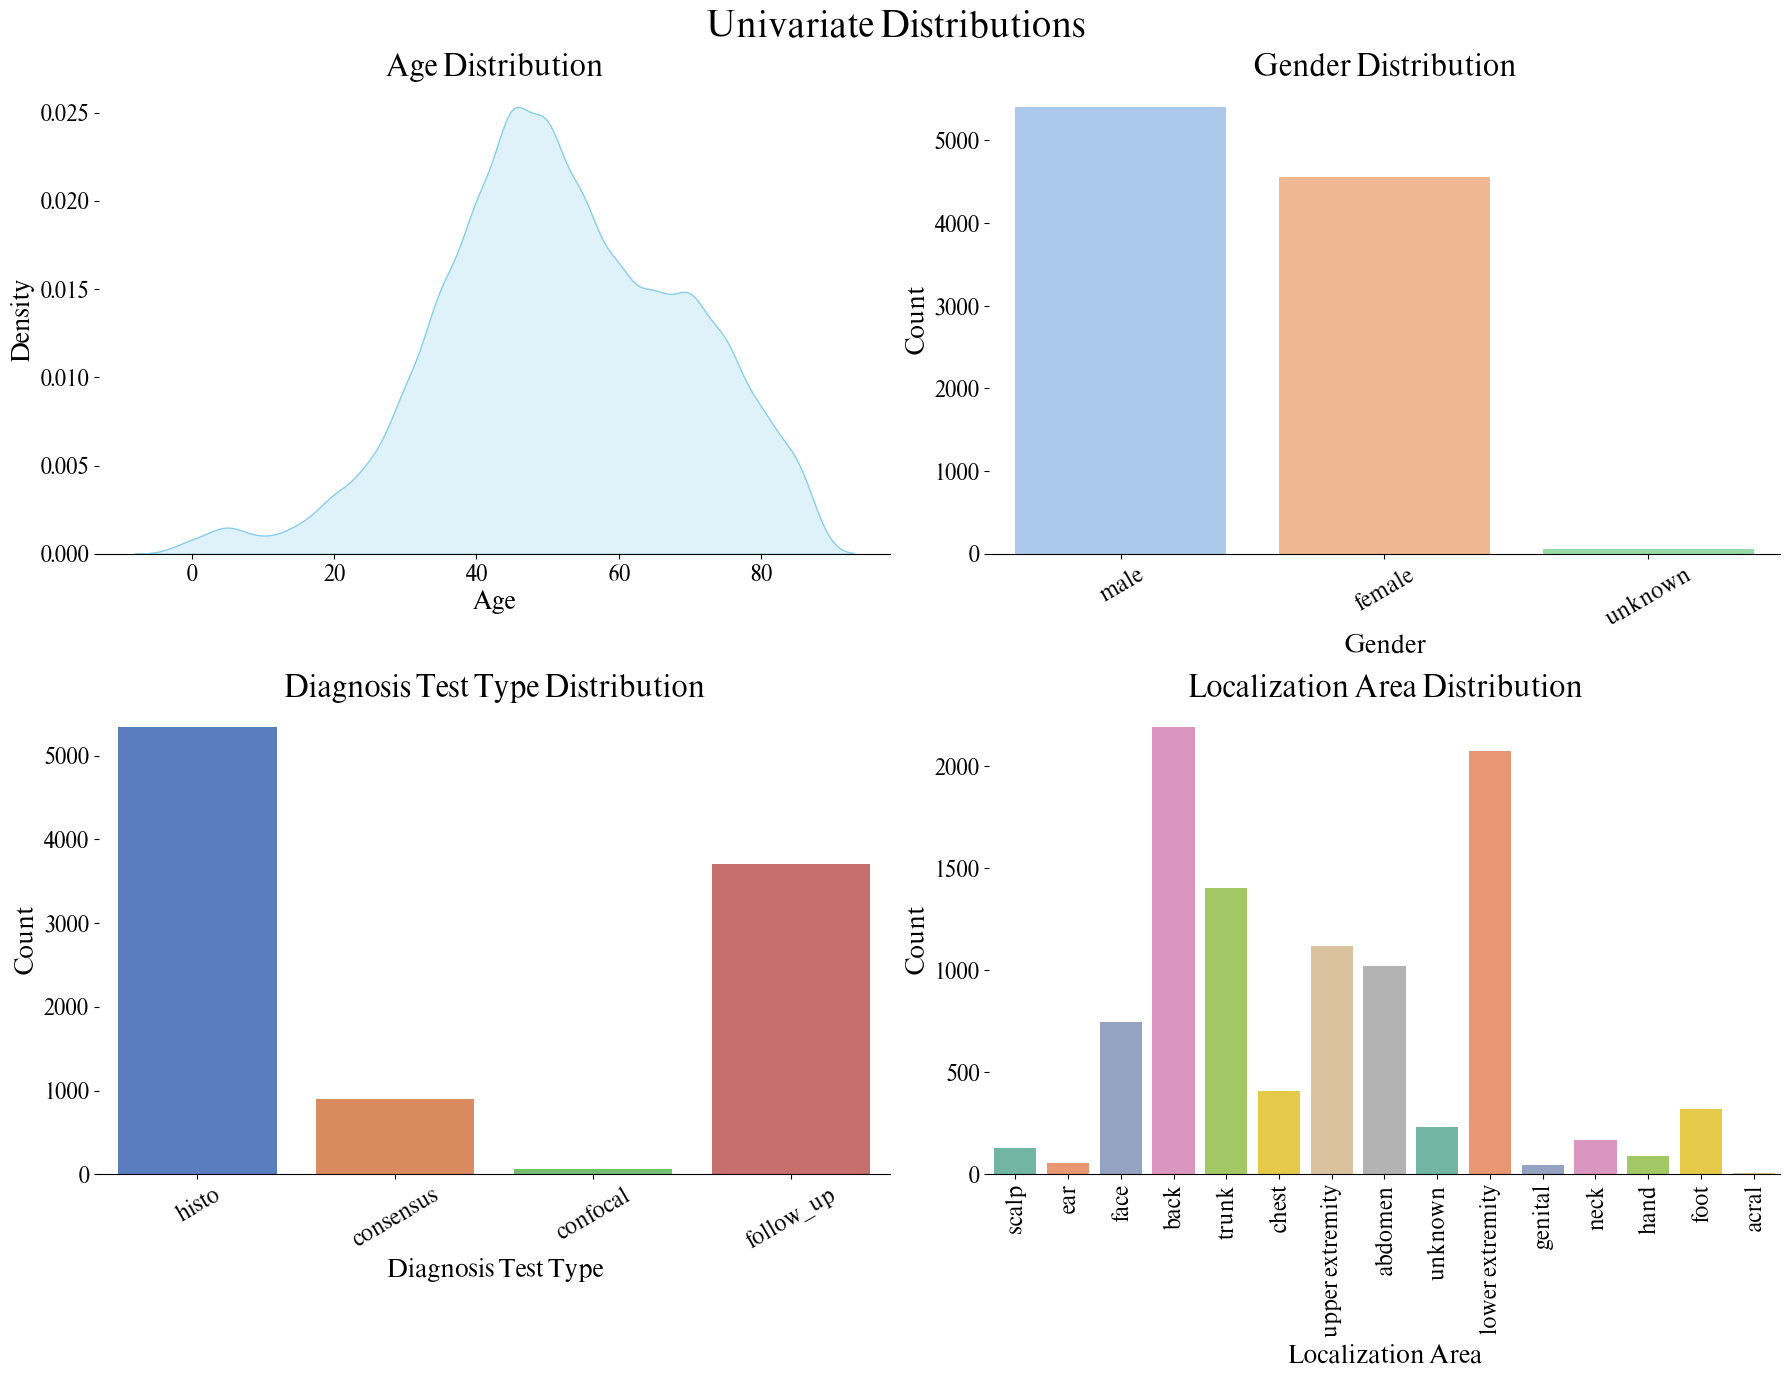

In [ ]:
plot_univariate_distributions(
    df=clean_df,
    save_path=f"{ASSETS_VISUALIZE_IMG_PATH}/univariate_distributions",
    fontsize=20
)

### **Bivariate EDA**

In [ ]:
def plot_age_boxplots(df, fontsize=20, save_path=None):
    """
    ฟังก์ชันนี้ใช้สร้างกราฟกล่อง (Boxplot) แสดงการกระจายอายุ
    โดยเปรียบเทียบตามเพศ (sex) และประเภทรอยโรค (dx)

    Args:
        df (DataFrame): ข้อมูลที่ต้องมีคอลัมน์ 'age', 'sex', 'dx'
        fontsize (int, optional): ขนาดตัวอักษรฐานสำหรับ labels และ titles
        save_path (str, optional): ถ้าระบุ จะบันทึกกราฟเป็นไฟล์ PNG และ SVG
    """
    plt.rcParams['axes.titlesize'] = fontsize
    plt.rcParams['axes.labelsize'] = fontsize * 0.85
    plt.rcParams['xtick.labelsize'] = fontsize * 0.75
    plt.rcParams['ytick.labelsize'] = fontsize * 0.75

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    sns.despine(left=True)

    # Gender vs Age
    sns.boxplot(x="sex", y="age", data=df, hue="sex", palette="pastel", legend=False, ax=axes[0])
    axes[0].set_xlabel("Gender")
    axes[0].set_ylabel("Age")
    axes[0].set_title("Gender vs Age Boxplot", fontsize=fontsize-2)
    axes[0].tick_params(axis="x", rotation=30)

    # Lesion Type vs Age
    sns.boxplot(x="dx", y="age", data=df, hue="dx", palette="muted", legend=False, ax=axes[1])
    axes[1].set_xlabel("Lesion Type")
    axes[1].set_ylabel("Age")
    axes[1].set_title("Lesion Type vs Age Boxplot", fontsize=fontsize-2)
    axes[1].tick_params(axis="x", rotation=30)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    fig.suptitle("Bivariate Distribution", fontsize=fontsize * 1.1)

    if save_path:
        plt.savefig(f"{save_path}.png", dpi=300, bbox_inches="tight")
        plt.savefig(f"{save_path}.svg", bbox_inches="tight")

    plt.show()

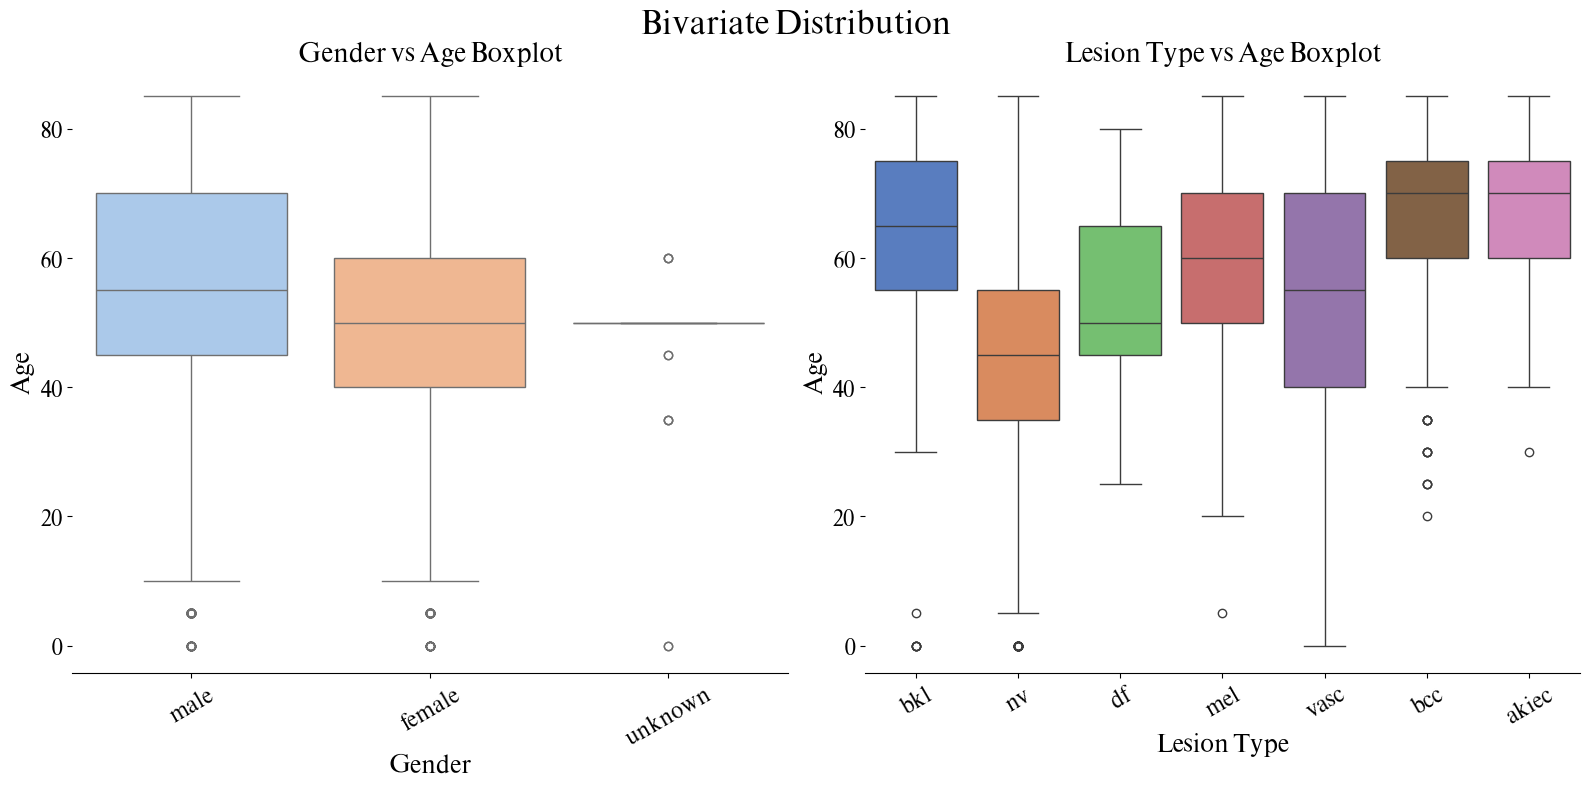

In [ ]:
plot_age_boxplots(
    df=clean_df,
    fontsize=20,
    save_path=f"{ASSETS_VISUALIZE_IMG_PATH}/bivariate_distributions"
)

### **Handle unknown value for gender column**

In [ ]:
print("Gender feature before cleaning:")
print(clean_df["sex"].value_counts())

Gender feature before cleaning:
sex
male       5406
female     4552
unknown      57
Name: count, dtype: int64


In [ ]:
clean_df = clean_df[clean_df["sex"] != "unknown"]
print(f"Gender feature after cleaning:")
clean_df["sex"].value_counts()

Gender feature after cleaning:


sex
male      5406
female    4552
Name: count, dtype: int64

### **Handle unknown value for localization area column**

In [ ]:
print(f"Localization feature before cleaning:")
clean_df["localization"].value_counts()

Localization feature before cleaning:


localization
back               2190
lower extremity    2077
trunk              1401
upper extremity    1118
abdomen            1020
face                745
chest               407
foot                316
unknown             187
neck                168
scalp               128
hand                 90
ear                  56
genital              48
acral                 7
Name: count, dtype: int64

In [ ]:
clean_df = clean_df[clean_df["localization"] != "unknown"]
print(f"Localization feature after cleaning:")
clean_df["localization"].value_counts()

Localization feature after cleaning:


localization
back               2190
lower extremity    2077
trunk              1401
upper extremity    1118
abdomen            1020
face                745
chest               407
foot                316
neck                168
scalp               128
hand                 90
ear                  56
genital              48
acral                 7
Name: count, dtype: int64

### **EDA Summary**

In [ ]:
print("Metadata before cleaning detail")
print("-------------------------------------------")
print(f"Shape of metadata: {clean_df.shape}")
print(f"Row of metadata: {clean_df.shape[0]}")
print(f"Column of metadata: {clean_df.shape[1]}")
print("-------------------------------------------")
print("Check missing value")
print("-------------------------------------------")
print(clean_df.isnull().sum())
print("-------------------------------------------")
print("Check data type")
print("-------------------------------------------")
print(clean_df.dtypes)
print("Check duplicate value")
print("-------------------------------------------")
print(f"Duplicate value count : {clean_df.duplicated().sum()}")

Metadata before cleaning detail
-------------------------------------------
Shape of metadata: (9771, 10)
Row of metadata: 9771
Column of metadata: 10
-------------------------------------------
Check missing value
-------------------------------------------
lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
filepaths        0
cell_type        0
cell_type_idx    0
dtype: int64
-------------------------------------------
Check data type
-------------------------------------------
lesion_id          object
image_id           object
dx                 object
dx_type            object
age               float64
sex                object
localization       object
filepaths          object
cell_type        category
cell_type_idx        int8
dtype: object
Check duplicate value
-------------------------------------------
Duplicate value count : 0


### **Export metadata after cleaning**

In [ ]:
clean_df.to_csv(f"{INDEX_PATH}/metadata_cleaning.csv", index=False)

## **Section 3: Verify the images**

In [ ]:
process_df = pd.read_csv(f"{INDEX_PATH}/metadata_cleaning.csv")
process_df

lesion_id      image_id     dx dx_type   age     sex localization  \
0     HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp   
1     HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp   
2     HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp   
3     HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp   
4     HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear   
...           ...           ...    ...     ...   ...     ...          ...   
9766  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen   
9767  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen   
9768  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen   
9769  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face   
9770  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back   

                                              filepaths  \
0     /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
1     /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
2     /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
3     /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
4     /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
...                                                 ...   
9766  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
9767  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
9768  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
9769  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
9770  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   

                          cell_type  cell_type_idx  
0     Benign keratosis-like lesions              2  
1     Benign keratosis-like lesions              2  
2     Benign keratosis-like lesions              2  
3     Benign keratosis-like lesions              2  
4     Benign keratosis-like lesions              2  
...                             ...            ...  
9766              Actinic keratoses              0  
9767              Actinic keratoses              0  
9768              Actinic keratoses              0  
9769              Actinic keratoses              0  
9770                       Melanoma              4  

[9771 rows x 10 columns]

In [ ]:
def verify_images(df, filepaths_col):
    """
        สำหรับตรวจสอบรูปภาพ เพื่อสแกนหาว่ามีภาพที่เสียหรือเปิดไม่ได้หรือไม่
        Args:
            df คือ Pandas dataframe ที่มี Column Filepaths สำหรับอ้างอิงไปยังตำแหน่งของรูปภาพ
            filepaths_col คือ ชื่อของ Column ที่เก็บตำแหน่งของรูปภาพ
        Return:
            List ที่เก็บชื่อไฟล์ที่พบปัญหา
    """
    corrupted_images = []
    filepaths = df[filepaths_col].values

    for filepath in tqdm(filepaths, desc="Verifying Images"):
        try:
            img = cv2.imread(filepath)
            if img is None:
                corrupted_images.append(filepath)
                os.remove(filepath) # ถ้าเจอภาพเสียลบออก
                print(f"Corrupted or unreadable image removed: {filepath}")
        except Exception as e:
            corrupted_images.append(filepath)
            os.remove(filepath) # ถ้าเจอภาพเสียลบออก
            print(f"Error verifying image: {filepath} - {e}")

    return corrupted_images

In [ ]:
corrupted_images = verify_images(process_df, "filepaths")

Verifying Images: 100%|██████████| 9771/9771 [02:22<00:00, 68.49it/s]


In [ ]:
print(f"Number of corrupted images: {len(corrupted_images)}")

Number of corrupted images: 0


## **Section 4: Split data into Train, Validation and Test**

In [ ]:
# หา Unique ตัวแบ่งกลุ่มที่จะ Split ข้อมูลโดยที่ไม่ซ้ำ
lesion_id = process_df.drop_duplicates(subset="lesion_id")
lesion_id = lesion_id[["lesion_id", "cell_type_idx"]]
print(f"Total images: {len(lesion_id)}")
print(f"Total unique lesions: {len(lesion_id)}")

Total images: 7263
Total unique lesions: 7263


**Split data into ratio train 80 validation 10 and test 10**

In [ ]:
train_lesions, temp_lesions = sklearn.model_selection.train_test_split(
    lesion_id,
    test_size=0.40,
    stratify=lesion_id["cell_type_idx"],
    random_state=SEED
)

val_lesions, test_lesions = sklearn.model_selection.train_test_split(
    temp_lesions,
    test_size=0.5,
    stratify=temp_lesions["cell_type_idx"],
    random_state=SEED
)

print(f"Total lesions: {len(lesion_id)}")
print(f"Train lesions: {len(train_lesions)}")
print(f"Val lesions:   {len(val_lesions)}")
print(f"Test lesions:  {len(test_lesions)}")

Total lesions: 7263
Train lesions: 4357
Val lesions:   1453
Test lesions:  1453


In [ ]:
train_ids = set(train_lesions["lesion_id"])
val_ids = set(val_lesions["lesion_id"])
test_ids = set(test_lesions["lesion_id"])

In [ ]:
df_train = process_df[process_df["lesion_id"].isin(train_ids)].copy()
df_val = process_df[process_df["lesion_id"].isin(val_ids)].copy()
df_test = process_df[process_df["lesion_id"].isin(test_ids)].copy()

In [ ]:
total_images = len(clean_df)

print(f"Total original images: {total_images}")
print(f"Train images: {len(df_train)} ({len(df_train)/total_images*100:.2f}%)")
print(f"Val images:   {len(df_val)} ({len(df_val)/total_images*100:.2f}%)")
print(f"Test images:  {len(df_test)} ({len(df_test)/total_images*100:.2f}%)")
print(f"Sum images:   {len(df_train) + len(df_val) + len(df_test)}")
print("-" * 30)

train_val_overlap = np.intersect1d(df_train["lesion_id"], df_val["lesion_id"])
train_test_overlap = np.intersect1d(df_train["lesion_id"], df_test["lesion_id"])
val_test_overlap = np.intersect1d(df_val["lesion_id"], df_test["lesion_id"])

# เพื่อรับประกันว่าข้อมูลจะไม่รั่วไหล
print(f"Overlap Train-Val: {len(train_val_overlap)}")
print(f"Overlap Train-Test: {len(train_test_overlap)}")
print(f"Overlap Val-Test: {len(val_test_overlap)}")

Total original images: 9771
Train images: 5836 (59.73%)
Val images:   1979 (20.25%)
Test images:  1956 (20.02%)
Sum images:   9771
------------------------------
Overlap Train-Val: 0
Overlap Train-Test: 0
Overlap Val-Test: 0


## **Section 5: Create dataset tree directory**

In [ ]:
def merge_directory(df_train, df_val, df_test,
                    filepaths_col, labels_col,
                    dest_dir, zip_dir=None):
    """
        สำหรับการ Merge source directories ตั้งแต่ 2 แหล่งขึ้นไป รวมเป็น 1 เดียว พร้อมกับสร้าง Sub folder ตาม Label ของแต่ละภาพ
        Structure folder:
            Main folder
            |
            |__train
               |_classA
                    |_IMG_1.jpg
               |_classB
                    |_IMG_2.jpg
            |__val
               |_classA
                    |_IMG_1.jpg
               |_classB
                    |_IMG_2.jpg
            |__test
               |_classA
                    |_IMG_1.jpg
               |_classB
                    |_IMG_2.jpg

        Args:
            df_train, df_val, df_test : DataFrame ของแต่ละชุดข้อมูล
            filepaths_col คือ ชื่อของ Column ที่เก็บตำแหน่งของรูปภาพ
            labels_col คือ ชื่อของ Column ที่เก็บ Label ของภาพ
            dest_dir คือ directory ปลายทาง
            zip_dir (optional) รับค่าเป็น Path ไฟล์เพื่อ zip ไฟล์เก็บไว้
    """
    os.makedirs(dest_dir, exist_ok=True)
    print(f"Destination directory has been created at: {dest_dir}")

    datasets = {
        "train": df_train,
        "val": df_val,
        "test": df_test
    }

    for split_name, df in datasets.items():
        print(f"\nProcessing {split_name} set ({len(df)} images)...")

        split_dir = os.path.join(dest_dir, split_name)
        os.makedirs(split_dir, exist_ok=True)

        # สร้าง subfolder ตาม label
        labels = df[labels_col].unique().tolist()
        for label in labels:
            label_dir = os.path.join(split_dir, label)
            os.makedirs(label_dir, exist_ok=True)

        # คัดลอกไฟล์
        filepaths = df[filepaths_col].values
        image_labels = df[labels_col].values

        for src_path, image_label in tqdm(
            zip(filepaths, image_labels),
            total=len(df),
            desc=f"Copying {split_name}"
        ):
            filename = os.path.basename(src_path)
            dst_path = os.path.join(split_dir, image_label, filename)
            shutil.copyfile(src_path, dst_path)

    if zip_dir:
        shutil.make_archive(zip_dir, "zip", dest_dir)
        print(f"Zip file has been created at: {zip_dir}")

In [ ]:
def update_path(df_train, df_val, df_test,
                base_path, filepaths_col, labels_col):
    """
    ฟังก์ชันนี้ใช้อัปเดตเส้นทางไฟล์ (file path) ใน DataFrame
    โดยรวม base_path, label และชื่อไฟล์เข้าด้วยกัน

    Args:
        df_train, df_val, df_test : DataFrame ของแต่ละชุดข้อมูล
        base_path (str): โฟลเดอร์หลักของไฟล์
        filepaths_col (str): ชื่อคอลัมน์ที่เก็บ path ของไฟล์เดิม
        labels_col (str): ชื่อคอลัมน์ที่เก็บ label ของไฟล์

    Returns:
        (df_train, df_val, df_test): DataFrame ทั้งสามชุดที่อัปเดต path แล้ว
    """
    def update_single(df, split_name):
        split_path = os.path.join(base_path, split_name)
        filenames = df[filepaths_col].apply(os.path.basename)
        labels = df[labels_col]
        df[filepaths_col] = split_path + "/" + labels + "/" + filenames
        return df

    df_train = update_single(df_train.copy(), "train")
    df_val = update_single(df_val.copy(), "val")
    df_test = update_single(df_test.copy(), "test")

    print(f"Updated paths for train ({len(df_train)}), val ({len(df_val)}), test ({len(df_test)})")
    return df_train, df_val, df_test

In [ ]:
merge_directory(
    df_train=df_train,
    df_val=df_val,
    df_test=df_test,
    filepaths_col="filepaths",
    labels_col="dx",
    dest_dir=BASE_DATASET_DIR,
    zip_dir=DATASET_ZIP_PATH
)

Destination directory has been created at: /content/ham10000Dataset

Processing train set (5836 images)...


Copying train: 100%|██████████| 5836/5836 [00:13<00:00, 424.94it/s]



Processing val set (1979 images)...


Copying val: 100%|██████████| 1979/1979 [00:03<00:00, 611.38it/s]



Processing test set (1956 images)...


Copying test: 100%|██████████| 1956/1956 [00:02<00:00, 744.97it/s]


Zip file has been created at: /content/drive/MyDrive/CP461/mainProject/datasets/ham10000Dataset


In [ ]:
df_train, df_val, df_test = update_path(
    df_train=df_train,
    df_val=df_val,
    df_test=df_test,
    base_path=BASE_DATASET_DIR,
    filepaths_col="filepaths",
    labels_col="dx"
) # Rename path to match new path

Updated paths for train (5836), val (1979), test (1956)


In [ ]:
df_train.head(3)

lesion_id      image_id   dx dx_type   age   sex localization  \
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                           filepaths  \
2  /content/ham10000Dataset/train/bkl/ISIC_002676...   
3  /content/ham10000Dataset/train/bkl/ISIC_002566...   
4  /content/ham10000Dataset/train/bkl/ISIC_003163...   

                       cell_type  cell_type_idx  
2  Benign keratosis-like lesions              2  
3  Benign keratosis-like lesions              2  
4  Benign keratosis-like lesions              2

In [ ]:
df_val.head(3)

lesion_id      image_id   dx dx_type   age     sex localization  \
8   HAM_0005132  ISIC_0025837  bkl   histo  70.0  female         back   
9   HAM_0005132  ISIC_0025209  bkl   histo  70.0  female         back   
13  HAM_0001949  ISIC_0025767  bkl   histo  70.0    male        trunk   

                                            filepaths  \
8   /content/ham10000Dataset/val/bkl/ISIC_0025837.jpg   
9   /content/ham10000Dataset/val/bkl/ISIC_0025209.jpg   
13  /content/ham10000Dataset/val/bkl/ISIC_0025767.jpg   

                        cell_type  cell_type_idx  
8   Benign keratosis-like lesions              2  
9   Benign keratosis-like lesions              2  
13  Benign keratosis-like lesions              2

In [ ]:
df_test.head(3)

lesion_id      image_id   dx dx_type   age   sex localization  \
0   HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1   HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
15  HAM_0007207  ISIC_0031326  bkl   histo  65.0  male         back   

                                            filepaths  \
0   /content/ham10000Dataset/test/bkl/ISIC_0027419...   
1   /content/ham10000Dataset/test/bkl/ISIC_0025030...   
15  /content/ham10000Dataset/test/bkl/ISIC_0031326...   

                        cell_type  cell_type_idx  
0   Benign keratosis-like lesions              2  
1   Benign keratosis-like lesions              2  
15  Benign keratosis-like lesions              2

## **Section 6: Visualization images**

In [ ]:
def plot_distribution(df, labels_col, save_path=None, fontsize=18, title="Class Distribution"):
    """
        แสดงจำนวนรูปภาพในแต่ละ Class แบบ Bar plot
        Args:
            df คือ Pandas dataframe ที่มี Column Label สำหรับอ้างอิง Label ของภาพ
            labels_col คือ ชื่อของ Column ที่เก็บ Label
            save_path (optional) หากใส่ filepath แบบ String จะทำการ Save Image เป็น .png และ .svg
            fontsize คือ ขนาด font (default = 18)
            title คือ ชื่อหัวข้อ
    """
    class_counts = df[labels_col].value_counts().reset_index()
    class_counts.columns = [labels_col, "count"]

    classes = sorted(df[labels_col].unique())
    palette = sns.color_palette("viridis", n_colors=len(classes))
    class_palette = {cls: palette[i] for i, cls in enumerate(classes)}

    plt.figure(figsize=(12, 8))
    sns.barplot(
        x=labels_col,
        y="count",
        data=class_counts,
        hue=labels_col,
        palette=class_palette,
        dodge=False,
        legend=False,
        order=classes
    )

    plt.title(title, fontsize=fontsize+2, weight="bold")
    plt.xlabel("Classes", fontsize=fontsize)
    plt.ylabel("Number of Images", fontsize=fontsize)
    plt.xticks(rotation=45, ha="right", fontsize=fontsize-2)
    plt.yticks(fontsize=fontsize-2)

    for i, count in enumerate(class_counts.set_index(labels_col).loc[classes]["count"]):
        plt.text(i, count, str(count), ha="center", va="bottom", fontsize=fontsize-2)

    plt.tight_layout()

    if save_path:
        plt.savefig(f"{save_path}.png", format="png", dpi=300, bbox_inches="tight")
        plt.savefig(f"{save_path}.svg", format="svg", bbox_inches="tight")

    plt.show()

In [ ]:
def visualize_image_by_class(df, filepaths_col, labels_col, labels_dict, save_path=None, fontsize=20, title="HAM10000 Dataset", num_images=7):
    """
        แสดงรูปภาพ Sample โดยแยกตาม Label ในแต่ละ Row
        Args:
            df คือ Pandas dataframe ที่มี Column Filepaths สำหรับอ้างอิงไปยังตำแหน่งของรูปภาพ และ Column Label สำหรับอ้างอิง Label ของภาพ
            filepaths_col คือ ชื่อของ Column ที่เก็บตำแหน่งของรูปภาพ
            labels_col คือ ชื่อของ Column ที่เก็บ Label ของภาพ
            labels_dict คือ dict ที่เก็บ key เป็นชื่อย่อของ Label และ value เป็นชื่อเต็มของ Label
            save_path (optional) หากใส่ filepath แบบ String จะทำการ Save Image เป็น .png และ .svg
            fontsize คือ ขนาด font (default = 18)
            title คือ ชื่อหัวข้อ
            num_images คือ จำนวนรูปภาพที่ต้องการแสดงในแต่ละแถว
    """
    unique_labels = df[labels_col].unique()
    num_classes = len(unique_labels)

    plt.figure(figsize=(num_images * 3, num_classes * 3))

    for i, label in enumerate(unique_labels):
        label_df = df[df[labels_col] == label]
        sample_paths = label_df[filepaths_col].sample(
            n=min(num_images, len(label_df)),
            random_state=SEED
        ).tolist()

        for j, filepath in enumerate(sample_paths):
            ax = plt.subplot(num_classes, num_images, i * num_images + j + 1)
            img = cv2.imread(filepath)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img)
            plt.axis("off")

            if j == 0:
                fullname = labels_dict.get(label, label)
                ax.set_title(f"{fullname} ({label})", loc="left", fontsize=fontsize, pad=10)

    plt.suptitle(title, fontsize=fontsize+2, weight="bold")
    plt.tight_layout()
    plt.subplots_adjust(hspace=-0.05)

    if save_path:
        plt.savefig(f"{save_path}.png", format="png", dpi=300, bbox_inches="tight")
        plt.savefig(f"{save_path}.svg", format="svg", bbox_inches="tight")

    plt.show()

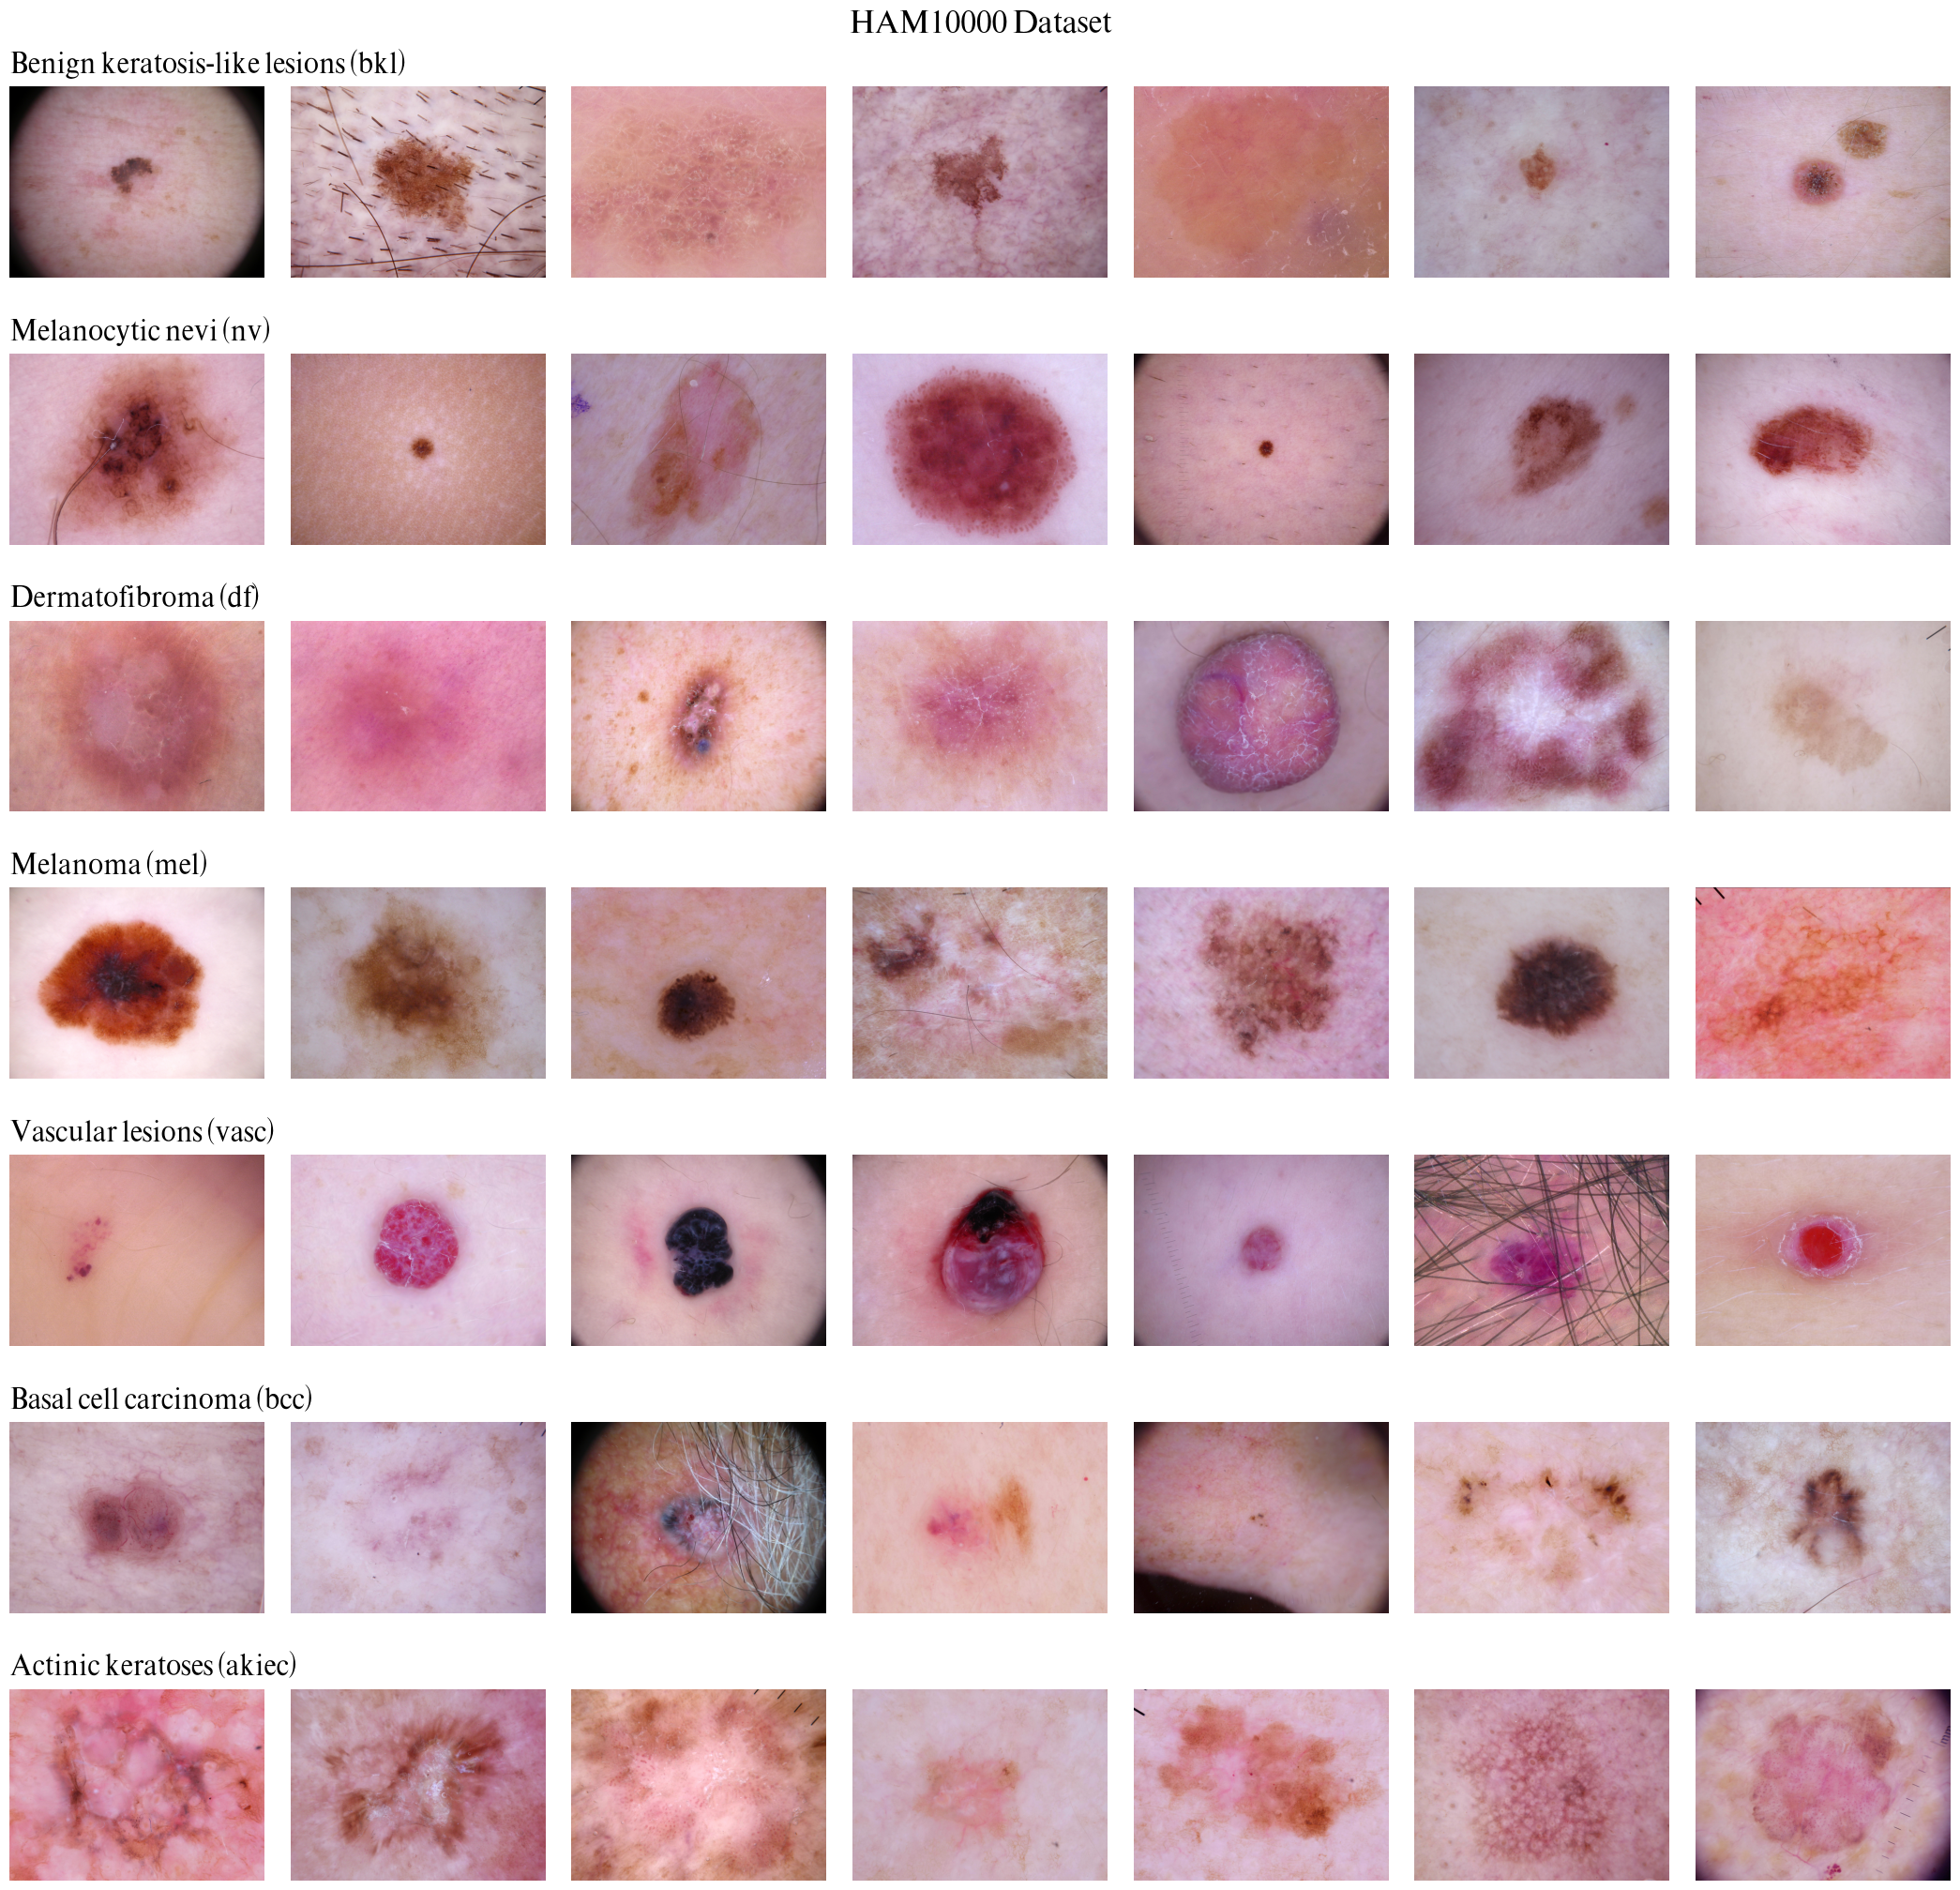

In [ ]:
visualize_image_by_class(
    df=df_train,
    filepaths_col="filepaths",
    labels_col="dx",
    labels_dict=lesion_type_dict,
    save_path=f"{ASSETS_VISUALIZE_IMG_PATH}/visualize_by_class",
    fontsize=20
)

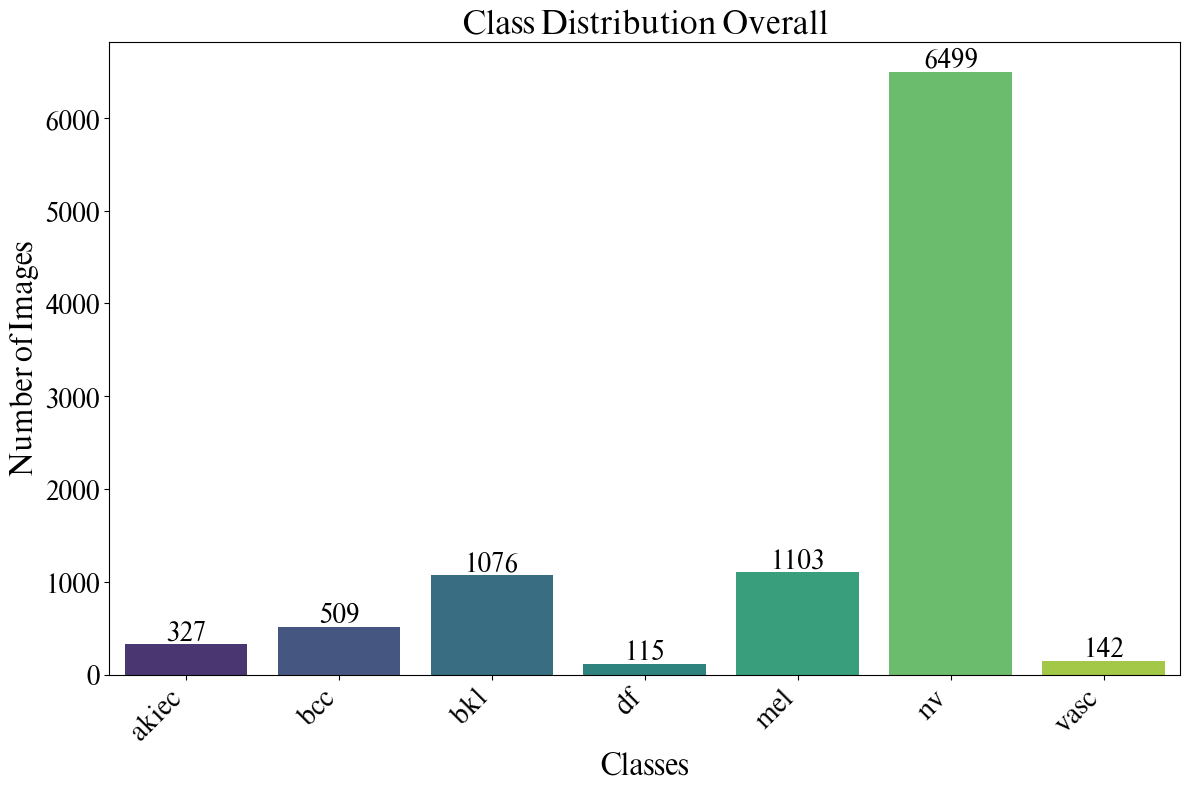

In [ ]:
plot_distribution(
    df=process_df,
    labels_col="dx",
    save_path=f"{ASSETS_VISUALIZE_IMG_PATH}/class_distribution",
    fontsize=20,
    title="Class Distribution Overall"
)

## **Section 7: Preprocess data for modeling**

In [ ]:
numeric_cols = ["age"]
categorical_cols = ["sex", "localization"] # ไม่รวม Target

preprocessing = sklearn.compose.ColumnTransformer(
    transformers=[
        ("numeric", sklearn.preprocessing.StandardScaler(), numeric_cols),
        ("category", sklearn.preprocessing.OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols)
    ],
    remainder="drop" # ลบคอลัมน์อื่นที่ไม่เกี่ยวข้องทิ้งไป
)

In [ ]:
#Fit preprocessor กับ df_train
print("Fitting preprocessor on df_train...")
preprocessing.fit(df_train)
print("Fit complete.")

Fitting preprocessor on df_train...
Fit complete.


In [ ]:
# Transform ข้อมูลทั้ง 3 ชุด
print("Transforming datasets...")
X_meta_train = preprocessing.transform(df_train)
X_meta_val = preprocessing.transform(df_val)
X_meta_test = preprocessing.transform(df_test)

print("Transform complete.")

# ตรวจสอบผลลัพธ์
print(f"X_meta_train shape: {X_meta_train.shape}")
print(f"X_meta_val shape:   {X_meta_val.shape}")
print(f"X_meta_test shape:  {X_meta_test.shape}")

Transforming datasets...
Transform complete.
X_meta_train shape: (5836, 17)
X_meta_val shape:   (1979, 17)
X_meta_test shape:  (1956, 17)


In [ ]:
feature_names = preprocessing.get_feature_names_out()
print(feature_names)

['numeric__age' 'category__sex_female' 'category__sex_male'
 'category__localization_abdomen' 'category__localization_acral'
 'category__localization_back' 'category__localization_chest'
 'category__localization_ear' 'category__localization_face'
 'category__localization_foot' 'category__localization_genital'
 'category__localization_hand' 'category__localization_lower extremity'
 'category__localization_neck' 'category__localization_scalp'
 'category__localization_trunk' 'category__localization_upper extremity']


In [ ]:
joblib.dump(preprocessing, f"{INDEX_PATH}/metadata_preprocessing.joblib")

['/content/drive/MyDrive/CP461/mainProject/datasets/indexSetting/metadata_preprocessing.joblib']

In [ ]:
df_train.to_csv(f"{INDEX_PATH}/metadata_train.csv", index=False)
df_val.to_csv(f"{INDEX_PATH}/metadata_val.csv", index=False)
df_test.to_csv(f"{INDEX_PATH}/metadata_test.csv", index=False)

## **Section 8: Visualization and fixed imbalanced for training data by transfrom image**

In [9]:
def visualize_augmentation(df, filepaths_col, transforms_sample, title,
                         n_rows, n_cols, n_samples=1,
                         seed=42, save_path=None, fontsize=16):
    """
    แสดงภาพต้นฉบับและภาพ Augmentation ใน Grid

    Args:
        df: DataFrame ที่มีคอลัมน์ Filepaths
        filepaths_col: ชื่อของ Column ที่เก็บตำแหน่งของรูปภาพ
        transforms_sample: list ของ tuple (name, albumentations transform)
        title: ชื่อ Title หลัก
        n_rows: จำนวนแถว
        n_cols: จำนวนหลัก
        n_samples: จำนวนภาพตัวอย่าง
        seed: random_state สำหรับ sample
        save_path: path สำหรับบันทึกรูป
        fontsize: ขนาดตัวอักษรของ title
    """
    samples = df.sample(n=n_samples, random_state=seed)

    for idx, row in samples.iterrows():
        img_path = row[filepaths_col]
        img = cv2.imread(img_path)
        if img is None:
            print(f"Error reading: {img_path}")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        n_aug = len(transforms_sample)

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
        axes = axes.flatten()

        # Original image
        axes[0].imshow(img)
        axes[0].set_title("Original Image", fontsize=fontsize)
        axes[0].axis("off")

        # Augmented images
        for i, (name, aug) in enumerate(transforms_sample):
            aug_img = aug(image=img)["image"]
            axes[i+1].imshow(aug_img)
            axes[i+1].set_title(name, fontsize=fontsize)
            axes[i+1].axis("off")

        # ปิดแกนที่เหลือ
        for j in range(n_aug+1, len(axes)):
            axes[j].axis("off")

        fig.suptitle(title, fontsize=fontsize+2)
        plt.tight_layout()

        if save_path:
            plt.savefig(f"{save_path}.png", format="png", dpi=300, bbox_inches="tight")
            plt.savefig(f"{save_path}.svg", format="svg", bbox_inches="tight")

        plt.show()

In [ ]:
def apply_transform_by_time(df, filepaths_col, labels_col, transform, base_dir,
                            transform_times=1, zip_dir=None):
    """
    Args:
        df: DataFrame ของ train set
        filepaths_col: ชื่อ column ที่เก็บ path ของภาพ
        labels_col: ชื่อ column ที่เก็บ label
        transform: Albumentations transform
        base_dir: โฟลเดอร์หลักของ train/val/test
        transform_times: จำนวนครั้งที่ต้องการ augment ต่อภาพหนึ่งภาพ (int >= 0)
        zip_dir (optional): path สำหรับ zip ผลลัพธ์

    Returns:
        train_df_aug: DataFrame ของ train set หลัง augment (รวม original + augmented)
    """
    df = df.copy()
    new_rows = []

    class_counts = df[labels_col].value_counts()
    max_count = class_counts.max()  # จำนวนภาพสูงสุดใน class ใด ๆ

    for label, count in class_counts.items():
        if count == max_count:
            print(f"Skipping augmentation for class {label} (max images: {count})")
            continue

        class_df = df[df[labels_col] == label]
        filepaths = class_df[filepaths_col].tolist()
        total_images = len(filepaths)

        if transform_times <= 0:
            print(f"Skipping augmentation for class {label} because transform_times <= 0")
            continue

        print(f"\nAugmenting class {label}, Original count: {total_images} images.")
        print(f"Augmenting each image {transform_times} times, total new images: {total_images * transform_times}\n")

        for i in tqdm(range(total_images * transform_times), desc=f"Class {label}"):
            img_path = filepaths[i % total_images]
            row_orig = class_df.iloc[i % total_images]  # copy metadata ของต้นฉบับ

            img = cv2.imread(img_path)
            if img is None:
                print(f"Error reading image: {img_path} skipped.")
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            augmented = transform(image=img)["image"]

            class_output_dir = os.path.dirname(img_path)  # train/class_name
            os.makedirs(class_output_dir, exist_ok=True)

            base_name = os.path.splitext(os.path.basename(img_path))[0]
            new_filename = f"{base_name}_aug_{i+1}.jpg"
            save_path = os.path.join(class_output_dir, new_filename)

            cv2.imwrite(save_path, cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR))

            # Copy metadata จากต้นฉบับ และเปลี่ยน filepaths
            new_row = row_orig.copy()
            new_row[filepaths_col] = save_path
            new_rows.append(new_row)

    # รวม original + augmented
    augmented_df = pd.DataFrame(new_rows)
    train_df_aug = pd.concat([df, augmented_df], ignore_index=True)

    # สร้าง zip ถ้ามีการระบุ
    if zip_dir:
        shutil.make_archive(zip_dir, "zip", base_dir)
        print(f"Zip file has been created at: {zip_dir}")

    return train_df_aug

In [16]:
# Geometric transform only
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Affine(
        translate_percent={"x": (-0.2, 0.2), "y": (-0.15, 0.15)},
        rotate=(-30, 30),
        shear=(-20, 20),
        scale=(0.7, 1.3),
        border_mode=cv2.BORDER_REPLICATE,
        p=1.0
    ),
    #A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
    #A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=15, p=0.3),
    #A.RandomGamma(gamma_limit=(80,120), p=0.3)
], seed=SEED)

In [27]:
# for visualization
preview_transforms = [
    ("Horizontal Flip", A.HorizontalFlip(p=1.0)),
    ("Translation", A.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.15, 0.15)}, border_mode=cv2.BORDER_REPLICATE, p=1.0)),
    ("Rotatation", A.Affine(rotate=(-30, 30), border_mode=cv2.BORDER_REPLICATE, p=1.0)),
    ("Shear", A.Affine(shear=(-20, 20), border_mode=cv2.BORDER_REPLICATE, p=1.0)),
    ("Zoom", A.Affine(scale=(0.7, 1.3), border_mode=cv2.BORDER_REPLICATE, p=1.0)),
    ("Brightness", A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1.0)),
    ("Hue", A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=15, p=1.0)),
    ("Gamma", A.RandomGamma(gamma_limit=(80,120), p=1.0)),
    ("Combined Transform", A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Affine(
        translate_percent={"x": (-0.2, 0.2), "y": (-0.15, 0.15)},
        rotate=(-30, 30),
        shear=(-20, 20),
        scale=(0.7, 1.3),
        border_mode=cv2.BORDER_REPLICATE,
        p=1.0
    ),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.4),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=15, p=0.4),
    A.RandomGamma(gamma_limit=(80,120), p=0.4)
], seed=SEED))
]

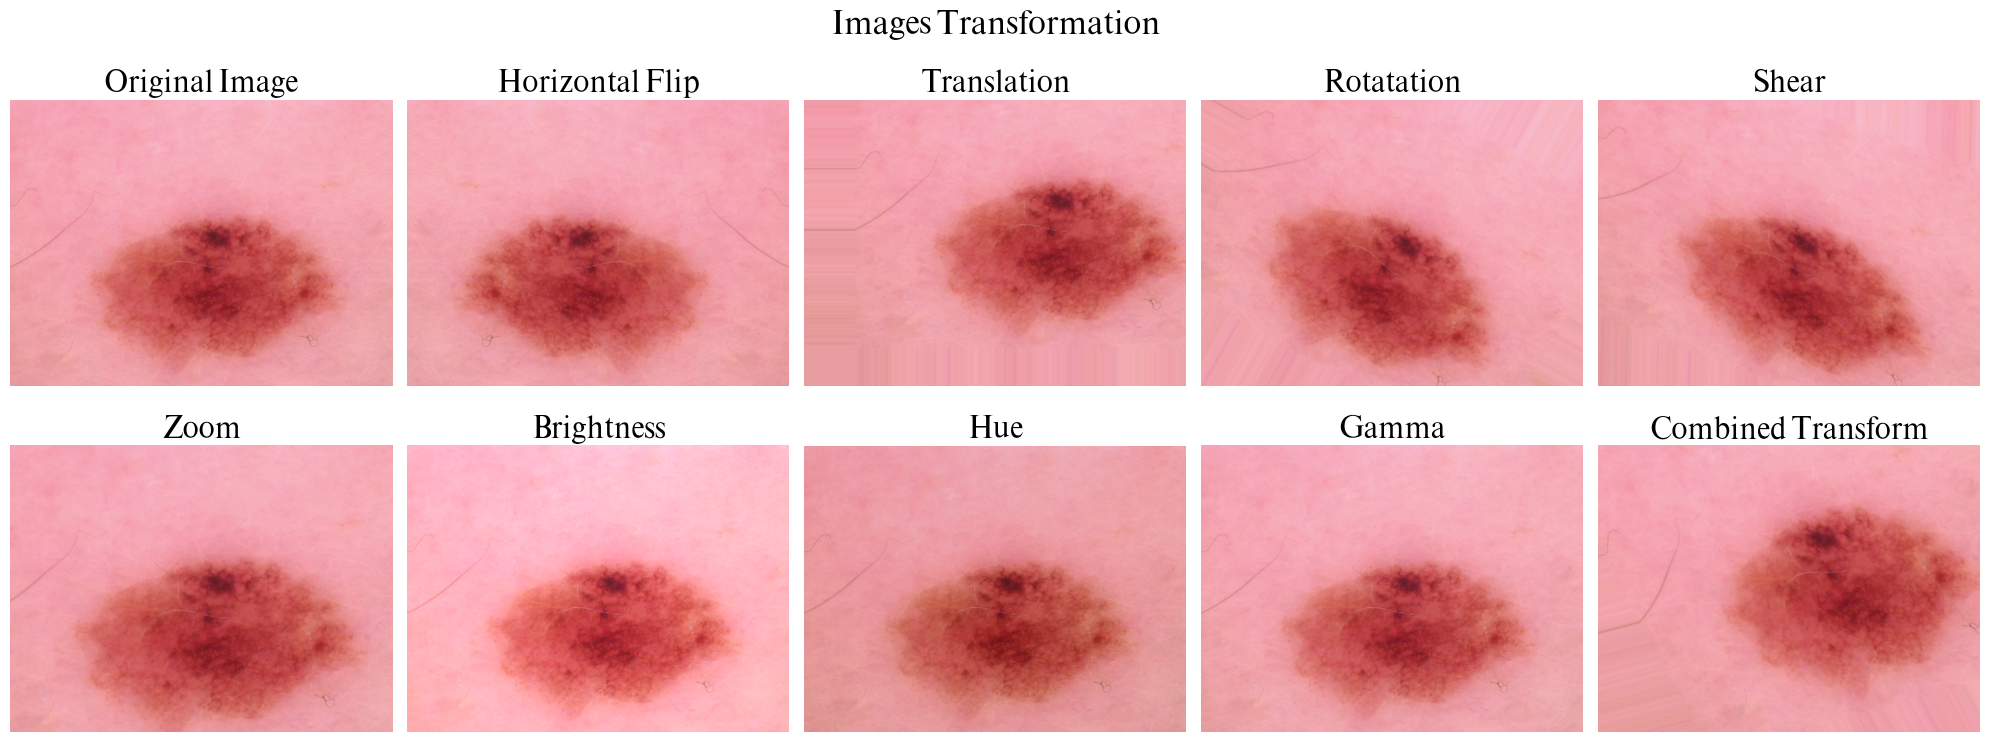

In [29]:
visualize_augmentation(
    df=df_train,
    filepaths_col="filepaths",
    transforms_sample=preview_transforms,
    title="Images Transformation",
    n_rows=2,
    n_cols=5,
    n_samples=1,
    seed=SEED,
    save_path=f"{ASSETS_VISUALIZE_IMG_PATH}/augmentation_sample",
    fontsize=20
)

In [ ]:
df_train_new = df_train.copy()
df_val_new = df_val.copy()
df_test_new = df_test.copy()

In [ ]:
merge_directory(
    df_train=df_train_new,
    df_val=df_val_new,
    df_test=df_test_new,
    filepaths_col="filepaths",
    labels_col="dx",
    dest_dir=OVER_DATASET_DIR,
    zip_dir=None
) # สำหรับ Oversamling Train

Destination directory has been created at: /content/ham10000DatasetOversampling

Processing train set (5836 images)...


Copying train: 100%|██████████| 5836/5836 [00:11<00:00, 512.98it/s]



Processing val set (1979 images)...


Copying val: 100%|██████████| 1979/1979 [00:07<00:00, 279.16it/s]



Processing test set (1956 images)...


Copying test: 100%|██████████| 1956/1956 [00:04<00:00, 449.81it/s]


In [ ]:
df_train_new, df_val_new, df_test_new = update_path(
    df_train=df_train_new,
    df_val=df_val_new,
    df_test=df_test_new,
    base_path=OVER_DATASET_DIR,
    filepaths_col="filepaths",
    labels_col="dx"
) # Rename path to match new path

Updated paths for train (5836), val (1979), test (1956)


In [ ]:
df_train_new.head(3)

lesion_id      image_id   dx dx_type   age   sex localization  \
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                           filepaths  \
2  /content/ham10000DatasetOversampling/train/bkl...   
3  /content/ham10000DatasetOversampling/train/bkl...   
4  /content/ham10000DatasetOversampling/train/bkl...   

                       cell_type  cell_type_idx  
2  Benign keratosis-like lesions              2  
3  Benign keratosis-like lesions              2  
4  Benign keratosis-like lesions              2

In [ ]:
df_val_new.head(3)

lesion_id      image_id   dx dx_type   age     sex localization  \
8   HAM_0005132  ISIC_0025837  bkl   histo  70.0  female         back   
9   HAM_0005132  ISIC_0025209  bkl   histo  70.0  female         back   
13  HAM_0001949  ISIC_0025767  bkl   histo  70.0    male        trunk   

                                            filepaths  \
8   /content/ham10000DatasetOversampling/val/bkl/I...   
9   /content/ham10000DatasetOversampling/val/bkl/I...   
13  /content/ham10000DatasetOversampling/val/bkl/I...   

                        cell_type  cell_type_idx  
8   Benign keratosis-like lesions              2  
9   Benign keratosis-like lesions              2  
13  Benign keratosis-like lesions              2

In [ ]:
df_test_new.head(3)

lesion_id      image_id   dx dx_type   age   sex localization  \
0   HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1   HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
15  HAM_0007207  ISIC_0031326  bkl   histo  65.0  male         back   

                                            filepaths  \
0   /content/ham10000DatasetOversampling/test/bkl/...   
1   /content/ham10000DatasetOversampling/test/bkl/...   
15  /content/ham10000DatasetOversampling/test/bkl/...   

                        cell_type  cell_type_idx  
0   Benign keratosis-like lesions              2  
1   Benign keratosis-like lesions              2  
15  Benign keratosis-like lesions              2

In [ ]:
df_train_new_transform = apply_transform_by_time(
    df=df_train_new,
    filepaths_col="filepaths",
    labels_col="dx",
    transform=transform,
    base_dir=OVER_DATASET_DIR,
    transform_times=5,
    zip_dir=OVER_DATASET_ZIP_PATH
)

Skipping augmentation for class nv (max images: 3878)

Augmenting class mel, Original count: 664 images.
Augmenting each image 5 times, total new images: 3320



Class mel: 100%|██████████| 3320/3320 [00:49<00:00, 67.25it/s]



Augmenting class bkl, Original count: 639 images.
Augmenting each image 5 times, total new images: 3195



Class bkl: 100%|██████████| 3195/3195 [00:51<00:00, 61.94it/s]



Augmenting class bcc, Original count: 302 images.
Augmenting each image 5 times, total new images: 1510



Class bcc: 100%|██████████| 1510/1510 [00:22<00:00, 67.92it/s]



Augmenting class akiec, Original count: 203 images.
Augmenting each image 5 times, total new images: 1015



Class akiec: 100%|██████████| 1015/1015 [00:14<00:00, 68.24it/s]



Augmenting class vasc, Original count: 87 images.
Augmenting each image 5 times, total new images: 435



Class vasc: 100%|██████████| 435/435 [00:07<00:00, 57.68it/s]



Augmenting class df, Original count: 63 images.
Augmenting each image 5 times, total new images: 315



Class df: 100%|██████████| 315/315 [00:04<00:00, 71.68it/s]


Zip file has been created at: /content/drive/MyDrive/CP461/mainProject/datasets/ham10000DatasetOversampling


In [ ]:
#Fit preprocessor กับ df_train_new_transform
print("Fitting preprocessor on df_train_new_transform...")
preprocessing.fit(df_train_new_transform)
print("Fit complete.")

# Transform ข้อมูลทั้ง 3 ชุด
print("Transforming datasets...")
X_meta_train_new_transform = preprocessing.transform(df_train_new_transform)
X_meta_val_new = preprocessing.transform(df_val_new)
X_meta_test_new = preprocessing.transform(df_test_new)

print("Transform complete.")

# ตรวจสอบผลลัพธ์
print(f"X_meta_train_new_transform shape: {X_meta_train_new_transform.shape}")
print(f"X_meta_val_new shape:   {X_meta_val_new.shape}")
print(f"X_meta_test_new shape:  {X_meta_test_new.shape}")

joblib.dump(preprocessing, f"{INDEX_PATH}/metadata_preprocessing_new.joblib")

Fitting preprocessor on df_train_new_transform...
Fit complete.
Transforming datasets...
Transform complete.
X_meta_train_new_transform shape: (15626, 17)
X_meta_val_new shape:   (1979, 17)
X_meta_test_new shape:  (1956, 17)


['/content/drive/MyDrive/CP461/mainProject/datasets/indexSetting/metadata_preprocessing_new.joblib']

In [ ]:
df_train_new_transform.to_csv(f"{INDEX_PATH}/metadata_train_new.csv", index=False)
df_val_new.to_csv(f"{INDEX_PATH}/metadata_val_new.csv", index=False)
df_test_new.to_csv(f"{INDEX_PATH}/metadata_test_new.csv", index=False)

## **Section 9: Preparation Summary**

In [ ]:
labels = process_df["dx"].unique().tolist()

total_count = []
train_count = []
aug_count = []
valid_count = []
test_count = []

for label in labels:
    total_count.append(process_df[process_df["dx"] == label].shape[0])
    train_count.append(df_train[df_train["dx"] == label].shape[0])
    aug_count.append(df_train_new_transform[df_train_new_transform["dx"] == label].shape[0])
    valid_count.append(df_val[df_val["dx"] == label].shape[0])
    test_count.append(df_test[df_test["dx"] == label].shape[0])

summary_df = pd.DataFrame({
    "Label": labels,
    "Total (100%)": total_count,
    "Train (59.73%)": train_count,
    "Augmented": aug_count,
    "Valid (20.25%)": valid_count,
    "Test (20.02%)": test_count
})
summary_df.to_csv(f"{INDEX_PATH}/dataset_description.csv", index=False)

print("Dataset overall description")
print("=======================================================================================================")
print(summary_df.to_string(index=False))
print("=======================================================================================================")
print(f"Training total count: {sum(train_count)}")
print(f"Augmented total count: {sum(aug_count)}")
print(f"Validation total count: {sum(valid_count)}")
print(f"Testing total count: {sum(test_count)}")

Dataset overall description
Label  Total (100%)  Train (59.73%)  Augmented  Valid (20.25%)  Test (20.02%)
  bkl          1076             639       3834             216            221
   nv          6499            3878       3878            1322           1299
   df           115              63        378              23             29
  mel          1103             664       3984             219            220
 vasc           142              87        522              27             28
  bcc           509             302       1812             110             97
akiec           327             203       1218              62             62
Training total count: 5836
Augmented total count: 15626
Validation total count: 1979
Testing total count: 1956


## **Section 10: For transformer**

In [44]:
numeric_cols = ["age"]
categorical_cols = ["sex", "localization"] # ไม่รวม Target

In [45]:
df_train_new = pd.read_csv(f"{INDEX_PATH}/metadata_train_new.csv")
df_val_new = pd.read_csv(f"{INDEX_PATH}/metadata_val_new.csv")
df_test_new = pd.read_csv(f"{INDEX_PATH}/metadata_test_new.csv")

In [46]:
print(f"train shape: {df_train_new.shape}")
print(f"val shape:   {df_val_new.shape}")
print(f"test shape:  {df_test_new.shape}")

train shape: (15626, 10)
val shape:   (1979, 10)
test shape:  (1956, 10)


In [47]:
numeric_preprocessor = sklearn.preprocessing.StandardScaler()
numeric_preprocessor.fit(df_train_new[numeric_cols])

X_num_train = numeric_preprocessor.transform(df_train_new[numeric_cols])
X_num_val = numeric_preprocessor.transform(df_val_new[numeric_cols])
X_num_test = numeric_preprocessor.transform(df_test_new[numeric_cols])

print(f"X_num_train shape: {X_num_train.shape}")
print(f"X_num_val shape:   {X_num_val.shape}")
print(f"X_num_test shape:  {X_num_test.shape}")

X_num_train shape: (15626, 1)
X_num_val shape:   (1979, 1)
X_num_test shape:  (1956, 1)


In [48]:
category_preprocessor = sklearn.preprocessing.OrdinalEncoder(
    handle_unknown="use_encoded_value",
    unknown_value=-1
)

category_preprocessor.fit(df_train_new[categorical_cols])

X_cat_train = category_preprocessor.transform(df_train_new[categorical_cols])
X_cat_val = category_preprocessor.transform(df_val_new[categorical_cols])
X_cat_test = category_preprocessor.transform(df_test_new[categorical_cols])

print(f"X_cat_train shape: {X_cat_train.shape}")
print(f"X_cat_val shape:   {X_cat_val.shape}")
print(f"X_cat_test shape:  {X_cat_test.shape}")

X_cat_train shape: (15626, 2)
X_cat_val shape:   (1979, 2)
X_cat_test shape:  (1956, 2)


In [49]:
numeric_feature_name = numeric_preprocessor.get_feature_names_out()
print(numeric_feature_name)

['age']


In [50]:
category_feature_name = category_preprocessor.get_feature_names_out()
print(category_feature_name)

['sex' 'localization']


In [51]:
joblib.dump(numeric_preprocessor, f"{INDEX_PATH}/numeric_preprocessing.joblib")
joblib.dump(category_preprocessor, f"{INDEX_PATH}/category_preprocessing.joblib")

print("Preprocessors saved!")

Preprocessors saved!
